(sec:deep-learning)=
# 深層学習による物体認識

前回、[特徴量抽出](sec:feature-extraction)では、画像から特徴量を検出し、それを画像認識に利用する方法を見てきた。

2000年台まで、画像認識の分野では、**画像を如何に特徴化するか**と**得られた特徴からどのように物体を認識するか**という二つの研究が中心となってきた。

そのために、SIFTを始めとする特徴量の改善や、カーネル法を用いたSVMの性能改善などが試みられてきたが、その性能は徐々に頭打ちになっていく。

### 深層学習の歴史

そんな折、彗星のごとく現れた技術がニューラルネットワークを多層化した深層学習である。実は、ニューラルネット自体は人間の脳のシナプス同士の結合を模したモデルとして1950年代から研究されていた。

最初にニューラルネットが日の目を見たのは1980年代で、この頃には、入力層、隠れ層、出力層の三層を持つニューラルネットがある程度の性能を出せることが知られていた。当然ながら、その当時も、より多層のニューラルネットワークを利用しようという考え自体はあり、検討が試みられたが、ニューラルネットワークの持つ多数のパラメータを上手く最適化する手法がなく、その時代には実現が難しいと考えられていた。

なお、多層のニューラルネットの考え方を最初に提唱したのは、当時NHKの放送技術研究所の研究員であった福島邦彦氏であるとされており、その論文は、驚くべきことに1980年に出版されている {cite}`fukushima1980neocognitron`。

2010年代に入ると、それまで下火だったニューラルネットが再び注目を集めることになる。それまで細々と続けられていたニューラルネットワークの研究の中で、パラメータの過学習や、最適化時の勾配消失といった問題が徐々に解決されるとともに、GPUを用いた汎用計算であるGPGPU (General Purpose Computing on GPU)により並列計算の公立が大幅に上昇するなど、ニューラルネットワークを取り巻く環境が徐々に変化してくる。そして、2012年に事件が起こる。

ImageNetと呼ばれる大規模画像データセットの識別チャレンジであるILSVRC (ImageNet Large Scale Visual Recognition Challenge)において、トロント大学のGeoffrey Hintonらの研究チームが、AlexNet (筆頭著者のfirst nameから)と呼ばれる二股のニューラルネットを用いて、2位のエラー率26.2%に大差をつけ、エラー率わずか17.0％を達成し、優勝する {cite}`krizhevsky2012imagenet`。この時の2位のチームが用いた手法はSIFT, Fisher Vector, SVMを組み合わせたものであった。

この優勝を皮切りに、2013年の大会ではオックスフォード大学のチームがVGGというネットワークで2位に入り、以後、2014年はGoogleのチームがGoogLeNetというネットワークで2位、2015年はMicrosoftのチームがResNetというネットワークで優勝する。

こうして、2016年くらいになると、現在のニューラルネットワークの構築において一般的になっている諸技術、例えば、

- Rectified Linear Unit (ReLU)
- Max Pooling
- Dropout
- Batch Normalization
- Skip Connection (Residual Block)
- Adaptive Momentum Estimation (Adam)

などの技術が、一通り出そろう。

さらには、この頃になるとNVIDIAのCaffeや、モントリオール大学のtheano、FacebookのTorch、そしてPreferred NetworkのChainerといった汎用の深層学習用ライブラリが多数登場する。これによって、深層学習の研究が一気に花開き、現在に至る。

---

**Google Colab用の準備**

In [289]:
IN_COLAB = True
try:
    import google.colab
    print("You are running the code in Google Colab.")
except:
    IN_COLAB = False
    print("You are running the code in the local computer.")

if IN_COLAB:
    !pip install torch torchvision torchaudio

You are running the code in the local computer.


**下準備のコード**

In [290]:
import os

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

try:
    from myst_nb import glue
except:
    glue = lambda *args, **kwargs: _

# 実験に使うサンプル数
n_samples = 30000
batch_size = 32
glue("n_samples", n_samples, display=False)
glue("batch_size", batch_size, display=False)

# グラフの設定
matplotlib.rcParams["figure.dpi"] = 150
sns.set(style="white", palette="colorblind")
color_palette = sns.color_palette("colorblind")

**平仮名73文字データセットの準備**

In [291]:
import zipfile

import requests

url = "http://lab.ndl.go.jp/dataset/hiragana73.zip"
filename = os.path.basename(url)

# HTTPリクエストを送ってデータサイズを取得
r = requests.get(url, stream=True)
total_size = int(r.headers.get("content-length", 0))
chunk_size = 65535

# "hiragana73"フォルダが存在し、その中身が空でないことを確認
if not os.path.exists("./hiragana73") or len(os.listdir("./hiragana73")) == 0:
    # 実際のファイルのダウンロード
    pbar = tqdm(total=total_size, unit="B", unit_scale=True)
    with open(filename, "wb") as f:
        for data in r.iter_content(chunk_size):
            f.write(data)
            pbar.update(chunk_size)

    # ダウンロードが完了したらZIPを展開する
    with zipfile.ZipFile(filename, "r") as f:
        f.extractall()

## PyTorchの基本

PyTorchには、いくつかのモジュールが用意されており、代表的なものが、

- `torch`
- `torch.nn`
- `torch.nn.functional`

の3つである。慣例的に、これらをこのような形でエイリアスを与えてインポートする。

In [292]:
# PyTorchのモジュール群
import torch
import torch.nn as nn
import torch.nn.functional as F

`torch`モジュールがテンソルデータそのもの(`torch.Tensor`等)や、データに対する操作 (`torch.exp`や`torch.transpose`等)が含まれる。

`torch.nn`モジュールには、ニューラルネットワークを構成するレイヤー (`nn.Linear`や`nn.Conv2d`等)や損失関数 (`nn.CrossEntropyLoss`や`nn.MSELoss`等)が含まれる。

`torch.nn.functional`モジュールには、`torch.nn`モジュールに含まれるクラス定義に対応する関数が用意されている。例えば`nn.Linear`に対応する関数として`F.linear`、`nn.MSELoss`に対応する関数として`F.mse_loss`、といった具合である。

また、インストールすることは必須ではないが、PyTorchに付属するライブラリにTorchVisionがある。TorchVisionは、主にコンピュータ・ビジョンへの応用を目的とした補助関数が多数用意されている。

これ以外にも、有名ネットワークモデルの学習済み重みなどが提供されており、`AlexNet`や`ResNet50`等のほか、`ViT`などの比較的新しいものも含まれている。

本資料では、画像の前処理に使う`transforms`モジュールだけを用いる。

In [183]:
# TorchVision
from torchvision import transforms

### torch.Tensor

PyTorchの中で変数を扱う場合、スカラーであってもベクトルであっても、はたまた行列であっても、共通で`torch.Tensor`という型を用いる。これは、NumPyの`np.array`とほとんど同じように使うことができる。

初期化をする方法には、いくつかあるが、大きく分けて、

- `torch.Tensor`のコンストラクタを呼び出す
- `torch.tensor`関数を用いて`Tensor`を作る
- NumPyの配列を最初に用意して`torch.from_numpy`関数を使う

の3つの方法がある。順に見ていこう。

#### torch.Tensorを使う

まず、`torch.Tensor`を用いる場合には、通常のPythonやNumPyの配列を指定して初期化する。この時、配列がどのような型であっても、PyTorchの`default_dtype`に指定された型 (初期値は`float32`)の型にキャストされる。

In [184]:
x_npy = np.arange(10)
print("NumPy's dtype:", x_npy.dtype)
x = torch.Tensor(x_npy)
print("Torch's dtype:", x.dtype)

NumPy's dtype: int64
Torch's dtype: torch.float64


このように、NumPyの配列としての型は`int64`型であるにも関わらず、`torch.Tensor`を用いることで、型が`float32`に変更されていることが分かる。なお、この初期の型は`torch.set_default_dtyoe`で変更することもできる。

In [185]:
torch.set_default_dtype(torch.float64)
x = torch.Tensor(x_npy)
print("Torch's dtype:", x.dtype)

Torch's dtype: torch.float64


#### torch.tensorを使う

`torch.Tensor`と関数が似ており、非常に紛らわしいが、厳密に言えば`torch.Tensor`はコンストラクタであり、`torch.tensor`は初期化用のユーティリティ関数である。`torch.tensor`にも、PythonやNumPyの配列を指定して`torch.Tensor`型の多次元配列を作ることができる。

In [186]:
x_npy = np.arange(10)
x = torch.tensor(x_npy)
print("Torch's dtype:", x.dtype)

Torch's dtype: torch.int64


`torch.tensor`は先ほどとは異なり、PythonやNumPyの配列で定義されている要素の型を引き継ぐ。そのため、上記の例では`torch.Tensor`の`dtype`が`int64`になっている。また、`torch.tensor`関数は、型を指定して`torch.Tensor`を作ることもできる。

In [187]:
x = torch.tensor(x_npy, dtype=torch.float32)
print("Torch's dtype:", x.dtype)

Torch's dtype: torch.float32


また、詳細については後述するが、PyTorchの自動微分の機能を使うために必要な`requires_grad`パラメータを指定することもできる。

In [188]:
x = torch.tensor(x_npy, dtype=torch.float32, requires_grad=True)
print(x)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float32,
       requires_grad=True)


このように`torch.tensor`関数は`torch.Tensor`のコンストラクタを呼び出す場合と比べて圧倒的に使い勝手が良い。

#### torch.from_numpy

`torch.from_numpy`関数は`torch.Tensor`と仕様はかなり似ているが、

- 引数としてNumPyの配列しか取ることができない
- `dtype`はNumPyのものを引き継ぐ

の2点が大きく異なる。 

In [189]:
x_npy = np.arange(10)
x = torch.from_numpy(x_npy)
print("Torch's dtype:", x.dtype)

Torch's dtype: torch.int64


また`torch.from_numpy`は元のNumPyの配列とデータを共有しており、元の配列の値を書き換えるとそれが反映されるという違いがある。

In [190]:
# torch.Tensorの場合
x_npy = np.arange(10)
x = torch.Tensor(x_npy)
print("Before:", x)
x_npy *= 2
print(" After:", x)

Before: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
 After: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])


In [191]:
# torch.from_numpyの場合
x_npy = np.arange(10)
x = torch.from_numpy(x_npy)
print("Before:", x)
x_npy *= 2
print(" After:", x)

Before: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
 After: tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])


正直なことを言えば、この違いを意識すべき場面は少ないが、時に問題が生じることがあるので、特段の理由がない限りは`torch.tensor`を使うのが、多くの場合で問題を引き起こす危険性が低い。

### torch.Tensorからの値の取り出し

また`torch.Tensor`型で何らかの演算を行った後で、それをPythonやNumPyの配列に戻したいと思うこともあるだろう。この場合には、Pythonの配列なら`tolist`関数、NumPyの配列なら`numpy`関数を用いる。

In [192]:
x = torch.arange(10)

# Pythonの配列に直す
x_list = x.tolist()
print("Type:", type(x_list))
print(x_list)

# NumPyの配列に直す
x_npy = x.numpy()
print("Type:", type(x_npy))
print(x_npy)

Type: <class 'list'>
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Type: <class 'numpy.ndarray'>
[0 1 2 3 4 5 6 7 8 9]


また、配列の値が1つである場合に限り、`item`関数を使って、その1つの値をPythonの数値型として取り出すこともできる。この`item`関数は、要素が2つ以上ある配列に対して呼び出すと例外になるので注意すること。

In [193]:
x = torch.tensor([1.0], dtype=torch.float32)
print(x.item())

1.0


## 自動微分

PyTorchに限らず、深層学習を支える重要な技術に**自動微分**がある。関数の微分は、損失関数の最小化といった最適化問題にとって重要な情報であり、例えば、最急降下法やニュートン法といったアルゴリズムは、それぞれ関数の1階微分 (勾配)と、2階微分 (Hesse行列)を用いる。

しかし、このような微分を求めるには、数学的に関数の微分を求めておく必要があり、特に関数が複雑な場合には、それを求めることは困難である (が、従来はMathematicaなどのソフトを使って、勾配を求めるコードを書き出していた)。

また、1階微分であれば、差分法によって近似をすることも可能ではあるが、数値精度の問題は残る。2階微分以上になると差分計算の誤差が蓄積していくため、数値的に満足な結果を得ることは非常に難しくなる。

### 自動微分の仕組み

**自動微分**は、プログラム的に、とある演算とその微分計算がペアとして定義されており、演算の列によって表される関数の微分は、各演算の微分から、合成関数の微分としての連鎖率 (chain rule)により計算される。

一例として、ここでは、

$$
f(x) = \cos(x^2)
$$

の微分を例にとって見てみよう。

ここで、$g(x) = x^2$, $h(x) = \cos x$とすると、$f$は$g$と$h$の合成関数として$f = h \circ g$と表せる。言うまでもなく、$f$の微分$f'$は、$h$と$g$の微分を用いて、

$$
\begin{aligned}
f'(x) &= \frac{\text{d}f}{\text{d}x} = \frac{\text{d}h}{\text{d}g} \frac{\text{d}g}{\text{d}x} \\
&= -\sin (g(x)) \cdot 2 x \\
&= -2x \sin (x^2)
\end{aligned}
$$

となる。ここで注目してほしいのは、計算の順序が、

1. $x$の値が与えられる
2. $y = x^2$の値を計算する
3. $z = \cos(y)$の値を計算する

となっているということである。導関数$f$の微分を計算するときには、この逆順に、

1. $z$の$z$に関する微分として$\text{d}z/\text{d}z=1$が与えられる
2. 既知の$y$から$\text{d}z/\text{d}y = (\text{d}z/\text{d}z) \cdot (\text{d}z/\text{d}y) = 1 \cdot (-\sin(y)) = -\sin(y)$を計算する
3. 既知の$x$から$\text{d}z/\text{d}x = (\text{d}z/\text{d}y) \cdot (\text{d}y/ \text{d}x) = (-\sin(y)) \cdot (2 x) = -2x \sin(x^2)$を計算する

という流れになっている。従って、各演算$y=f(x)$において、

- 演算の入力$x$を保持しておく
- 演算の導関数$\text{d}y/\text{d}x$を定義しておく

という準備をしておけば、最終出力$z$の$y$に関する微分$\text{d}z/\text{d}y$が与えられれば、連鎖率を用いて$\text{d}z/\text{d}x$が求まる、という訳である。

### 自動微分の利用

では、上記の議論をPyTorchを用いて実験してみる。前述の通り、`torch.tensor`関数に`requires_grad`パラメータを指定することで、自動微分により勾配が計算される変数を作ることができる。

In [194]:
# 変数を作成
x = torch.tensor([2.0], requires_grad=True)

なお、一度、作成した`Tensor`に対して自動微分を有効にしたい場合には`requires_grad_`関数に`True`を渡す。

In [195]:
x = x.requires_grad_(True)

それでは、ここで定義した$x$を用いて変数を用いて、$z = \cos(x^2)$を段階的に計算してみる。

In [196]:
# y = g(x) = x^2の計算
y = x * x
print("y = g(x) = {:.1f}".format(y.item()))

# z = cos(y)の計算
z = torch.cos(y)
print("z = h(y) = {:.5f}".format(z.item()))

y = g(x) = 4.0
z = h(y) = -0.65364


最終的な$z$の$x$に関する微分を求めるには、`z.backward()`という関数を呼び出せば良い。ただし、この関数は単純にはスカラーの出力にしか使えないので注意が必要。

In [197]:
# 微分の計算
z.backward()

すると、予め自動微分を有効にしておいた変数には`grad`というメンバが追加され、そこに微分の値が代入される。**なお、`backward`関数は、デフォルトでは、一度呼び出すと同じ変数に対して再度呼び出すことはできないようになっている(メモリをできるだけ削減するため)**。同じ関数に対して、何度も`backward`を呼び出したい場合には、`backward`関数のパラメータに`retain_graph=True`を渡すこと (例外のメッセージにも同様のことが書かれている)。

In [198]:
try:
    z.backward()
except Exception as e:
    print("Exception:", e)

Exception: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


In [199]:
dzdx_autograd = x.grad
print("autograd: dz/dx = {:.5f}".format(dzdx_autograd.item()))

dzdx_analytic = -2.0 * x * torch.sin(x * x)
print("analytic: dz/dx = {:.5f}".format(dzdx_analytic.item()))

autograd: dz/dx = 3.02721
analytic: dz/dx = 3.02721


以上から、自動微分によって、正しく演算の微分が計算できていることが確認できた。

上記と同等の計算は、単に入力となっている$x$に関する勾配を求めたいだけであれば `torch.autograd.grad`を用いて、以下のように書くこともできる。なお、`torch.autograd.grad`関数の戻り値は、配列になっているので注意すること。

In [200]:
x = torch.tensor([2.0], requires_grad=True)
z = torch.cos(x * x)
dzdx = torch.autograd.grad(z, inputs=x)
print("autograd.grad: dz/dz = {:.5f}".format(dzdx[0].item()))

autograd.grad: dz/dz = 3.02721


```{admonition} 計算グラフ
:class: important

上記の計算では、$y = x^2$, $z = \cos(y)$として、連鎖律を用いて微分の計算を行った。このように、「ある計算の結果」を「次の計算で用いる」というような、計算の繋がりによって作られるグラフ構造のことを**計算グラフ**と呼ぶ。通常、四則演算や関数の計算などの多くの計算は単項演算 (変数1つに対して行われる演算、$x^2$や$\cos(x)$など)と二項演算 (変数2つに対して行われる演算、$x + y$や$x^y$など)に分けられ、3つ以上の変数が絡む演算も基本的には単項演算と二項演算の組み合わせによって表現できる。

自動微分においては、計算の過程でこのような計算グラフをライブラリが内部的に構築しており、グラフを遡っていくことで、「最終的な出力」の「グラフ中に現れた変数」に関する微分を計算している。PyTorchの`backward`等の関数に渡せるパラメータの中にも`retain_graph`や`create_graph`など、「グラフ」という言葉を含むものがあるのはこのためである。
```

### 自動微分可能な演算の定義

PyTorchを使うと、自分で微分可能な演算を定義することもできる。関数を定義するための一般的な方法は、`torch.autograd.Function`を継承したクラスを定義し、そこに静的メソッドとして`forward`と`backward`の二つの関数を実装するというものである。

`forward`内で計算済みの変数で、`backward`の計算でも使うものは`ctx.save_for_backward(...)`を用いて`backward`関数に渡すことができる。変数の取り出しには`ctx.saved_tensors`を用いる。以下の例では、$\cos(x)$を例にとって、実際に微分可能な演算を定義してみる。

In [201]:
from torch.autograd import Function


class MyCosine(Function):
    @staticmethod
    def forward(ctx, x):
        y = torch.cos(x)
        ctx.save_for_backward(x, y)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        x, y = ctx.saved_tensors
        return grad_output * (-torch.sin(x))

この実装では、`forward`の中で、$y = \cos(x)$として、戻り値を計算した後に、入力の$x$と出力の$y$の値を`save_for_backward(x, y)`として`backward`側でも使えるようにしている。今回の計算では、$\cos(x)$の微分が$-\sin(x)$であるため、必ずしも$y$を`backward`側で使えるようにしておく必要はない。しかし、例えば$\exp(x)$やシグモイド関数$1 / (1 + \exp(x))$のように、導関数のなかに自分自身を含むようなものも多く、計算量の観点から、`forward`での出力を`backward`側で使えるようにしておくことが多い。

この`Function`型のサブクラスは`MyCosine.apply`のように呼び出すことで関数の`forward`が呼び出されて、その計算結果が使われた出力において`backward`が呼び出されると、自動的に`MyCosine`の`backward`のその計算の中で呼び出されるようになる。

PyTorch内部の実装においては、上記のような`Function`のサブクラスを内部で呼び出すような関数を定義している場合が多く、それに従って`my_cos`関数を定義しておく。

In [202]:
def my_cos(x):
    return MyCosine.apply(x)

これを用いて、再度 $\cos(x^2)$の微分を計算してみると、以下のように正しく計算が行えていることが分かる。

In [203]:
x = torch.tensor([2.0], requires_grad=True)
y = x * x
z = my_cos(y)
z.backward()
print("my cosine: dzdx = {:.5f}".format(x.grad.item()))

my cosine: dzdx = 3.02721


### 二階微分の計算

続いて、前述の$f(x) = \cos(x^2)$の二階微分$f^{''}(x) = -2 \sin(x^2) - 4x^2 \cos(x^2)$の計算を自動微分で行ってみる。

実は、自動微分を使えば、高階微分を計算することも容易で、二階導関数を求めたい場合、一階導関数の計算中に計算グラフを遡っていく計算に対して、別の計算グラフを構築すれば良い。この計算グラフを再度遡って微分を求めることで二階微分が求まる、というわけである。

例えば、先ほどの計算であれば、連鎖律の途中で、$2x$の計算や$-\sin(x)$の計算が発生していたが、これらの計算について、途中結果を保存し、その微分計算が行えるように計算グラフを構築することができる。なお、二階微分を計算するときには`backward`関数の代わりに、`torch.autograd.grad`を使わないと警告メッセージが出るので注意すること (計算自体はできる)。

In [204]:
x = torch.tensor([2.0], requires_grad=True)
y = x * x
z = torch.cos(y)
dzdx = torch.autograd.grad(z, inputs=x, create_graph=True)
ddz_ddx_auto = torch.autograd.grad(dzdx, inputs=x)
ddz_ddx_analy = -2.0 * torch.sin(x**2.0) - 4.0 * x**2.0 * torch.cos(x**2)
print("autograd: ddz_ddx = {:.5f}".format(ddz_ddx_auto[0].item()))
print("analytic: ddz_ddx = {:.5f}".format(ddz_ddx_analy.item()))

autograd: ddz_ddx = 11.97190
analytic: ddz_ddx = 11.97190


このように、二階微分の場合も正しく計算できていることが分かる。以後、より高階な微分であっても`torch.autograd.grad`の引数で`create_graph=True`を指定する限りは計算し続けることができる。

### 多変数関数の微分

続いては、変数が2つ以上の場合の微分 (勾配)について見てみる。今回は例としてReosenbrock関数と呼ばれる、以下の関数について微分を計算してみる。

$$
f(x, y) = a (x - 1)^2 + b(y - x^2)^2
$$

この関数において$a = 1$, $b = 100$とするとして、二次元平面上に値をプロットすると以下のようになる (カラーバーは対数の値に対して計算されている)。

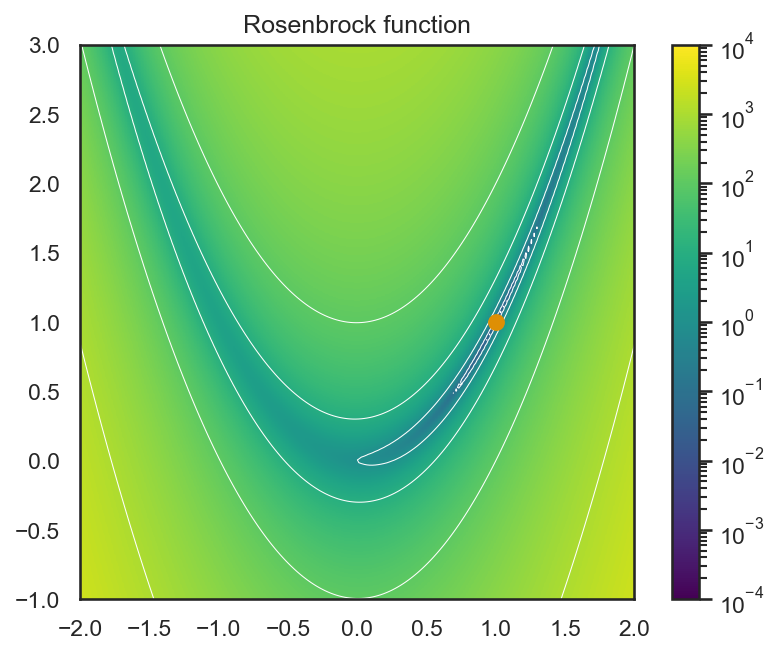

In [234]:
from matplotlib.colors import LogNorm

xs = np.linspace(-2.0, 2.0, 200)
ys = np.linspace(-1.0, 3.0, 200)
xs, ys = np.meshgrid(xs, ys)
extent = (-2.0, 2.0, -1.0, 3.0)
rosen = (1.0 - xs) ** 2.0 + 100.0 * (ys - xs**2.0) ** 2.0

fig, ax = plt.subplots()
mappable = ax.imshow(
    np.flip(rosen, axis=0), cmap="viridis", extent=extent, norm=LogNorm(vmin=1e-4, vmax=1.0e4)
)
ax.set(title="Rosenbrock function")
ax.contour(xs, ys, rosen, colors=["white"], linewidths=[0.5], norm=LogNorm(vmin=1e-4, vmax=1.0e4))
ax.scatter([1.0], [1.0], s=50, marker="o", color=color_palette[1], zorder=100)
fig.colorbar(mappable, ax=ax)
plt.show()

この関数は、$(1.0, 1.0)$の点を打った場所が関数の最小値をとる箇所になっているのだが、最小値の近傍が非常に狭い谷のような形になっており、さらにその谷が放物線上に湾曲しているため、この赤点の位置の最小値を求めることが困難であるとされている。

まずは$(x, y) = (0, 0)$として、Rosenbrock関数自体の値を計算してみる。

In [206]:
x = torch.tensor([0.0, 0.0], requires_grad=True)
f = (x[0] - 1.0) ** 2.0 + 100.0 * (x[1] - x[0] ** 2.0) ** 2.0
print(f)

tensor(1., grad_fn=<AddBackward0>)


次に、単一の変数の場合と同様に、出力の`f`に対して`backward`を呼び出して、$x, y$ (上記のコードでは`x`の0番目と1番目の要素に対応)に関する微分を求める。

In [207]:
f.backward()
print(x.grad)

tensor([-2.,  0.])


Rosenbrock関数の$x$, $y$に関する偏微分は、それぞれ

$$
\begin{align}
\frac{\partial f}{\partial x} &= 2a (x -1) - 4bx(y - x^2) \\
\frac{\partial f}{\partial y} &= 2b (y - x^2)
\end{align}
$$

であるので、$a = 1, b= 100$かつ$(x, y) = (0, 0)$であるとき、導関数の値は$(-2, 0)$になっており、上記の自動微分による結果と一致する。

---

続いては、Rosenbrock関数の二階導関数としてのHesse行列 (Hessianとも言う)を求めてみる。この場合は、先ほどの1変数の場合よりは多少工夫が必要になる。
まずは、`f`に対して`torch.autograd.grad`を計算する。

In [208]:
x = torch.tensor([0.0, 0.0], requires_grad=True)
f = (x[0] - 1.0) ** 2.0 + 100.0 * (x[1] - x[0] ** 2.0) ** 2.0
grad = torch.autograd.grad(f, inputs=x, create_graph=True)
print(grad)

(tensor([-2.,  0.], grad_fn=<AddBackward0>),)


安直には、この`grad`に対して、もう一度`torch.autograd.grad`関数を適用すれば良さそうだが、前述の通り`backward`関数や`torch.autograd.grad`関数は、出力がスカラー出ない場合には使うことができない。

In [209]:
try:
    H = torch.autograd.grad(grad, inputs=x)
except Exception as e:
    print("Exception:", e)

Exception: grad can be implicitly created only for scalar outputs


従って、ここで計算に一工夫が必要になる。ここで連鎖律の計算を思い出してほしい。連鎖律を計算するとき、スカラー値スカラー関数の場合には、$\text{d}z / \text{d}z = 1$から、連鎖律が始まり、その前の計算の微分を順に乗していくことで最終的な入力変数に関する微分を計算していたのであった。

この理屈で言えば、出力が二次元ベクトルであるような関数において、連鎖律のスタートとなるべき値は

$$
\begin{align}
\left( \frac{\partial x}{\partial x}, \frac{\partial y}{\partial x} \right) = (1, 0)
\left( \frac{\partial x}{\partial y}, \frac{\partial y}{\partial y} \right) = (0, 1)
\end{align}
$$

の2つとなることに気づく。そこで、このそれぞれを連鎖律のスタートとして`grad_outputs`パラメータに指定して`torch.autograd.grad`を呼び出してみる。

In [210]:
ddf_dxx = torch.autograd.grad(
    grad, inputs=x, grad_outputs=torch.tensor([1.0, 0.0]), retain_graph=True
)[0]
ddf_dyy = torch.autograd.grad(
    grad, inputs=x, grad_outputs=torch.tensor([0.0, 1.0]), retain_graph=True
)[0]
H = torch.stack([ddf_dxx, ddf_dyy], axis=0)

In [211]:
print(H)

tensor([[  2.,   0.],
        [  0., 200.]])


Rosenbrock関数のHesse行列は、解析的には

$$
\mathbf{H} = \begin{bmatrix}
2a + 4b (y - x^2) + 8bx^2 & -4bx \\
-4bx & 2b
\end{bmatrix}
$$

であるので、$a = 1, b = 100$, $(x, y) = (0, 0)$の時には、

$$
\mathbf{H} = \begin{bmatrix}
2 & 0 \\ 0 & 200
\end{bmatrix}
$$

となり、自動微分の結果が解析的な微分結果と一致していることが分かる。

## ニュートン法の実装

それでは、ここで練習としてニュートン法を用いてRosenbrock関数の最小値を求めてみよう。ニュートン法は、Hesse行列$\mathbf{H}$と、$f$の勾配$\nabla f$を用いて、

$$
\boldsymbol\delta = \mathbf{H}^{-1} \nabla f
$$ (eq:newton-step)

のように更新幅を計算するような、繰り返し最適化法の一種である。これは、関数$f(\mathbf{x})$の$\boldsymbol\delta$周りのTaylor展開により、

$$
f(\mathbf{x} + \boldsymbol\delta) \approx f(\mathbf{x}) + \frac{1}{1!} \boldsymbol\delta^\top \nabla f(\mathbf{x}) + \frac{1}{2!} \boldsymbol\delta^\top \mathbf{H} \boldsymbol\delta
$$

となることに起因する。この式を変形すると、

$$
\frac{\text{d} f}{\text{d} \boldsymbol\delta}(\mathbf{x}) = \nabla f(\mathbf{x}) + \frac{1}{2} \mathbf{H}\boldsymbol\delta
$$

という式が得られる。従って、Taylor展開の第2項までで元の関数を近似した範囲においては、$\text{d} f / \text{d}\boldsymbol\delta = \mathbf{0}$となるような場所に移動することで、関数の最小値に近づくことができる (これは、関数を局所的に二次関数で近似して、その二次関数の「底」に移動することに対応する)。

実際には、最小化すべき関数が局所的に二次関数で近似できることばかりではないので、通常は{eq}`eq:newton-step`で求まった更新方向に小さな定数$\alpha$を乗じて$\mathbf{x}$の値を

$$
\mathbf{x}^{t+1} = \mathbf{x}^t + \alpha \boldsymbol\delta
$$

のように更新することが多い。

では、ここまでの議論を踏まえて、実際に自動微分により求めたHesse行列を用いてRosenbrock関数を最小化してみよう (以下にコードと実行結果を示すが、まずは自分自身で考えてみてほしい)。

In [282]:
def rosenbrock(x):
    return (x[0] - 1.0) ** 2.0 + 100.0 * (x[1] - x[0] ** 2.0) ** 2.0


def calc_newton_step(f, x):
    grad = torch.autograd.grad(f, inputs=x, create_graph=True)[0]
    gx = torch.autograd.grad(
        grad, inputs=x, grad_outputs=torch.tensor([1.0, 0.0]), retain_graph=True
    )[0]
    gy = torch.autograd.grad(
        grad, inputs=x, grad_outputs=torch.tensor([0.0, 1.0]), retain_graph=True
    )[0]
    H = torch.stack([gx, gy], axis=0)

    return torch.linalg.solve(H, grad)


x = torch.tensor([0.0, 0.0], requires_grad=True)
pts = []
for i in range(100):
    pts.append(x.detach().numpy())
    fx = rosenbrock(x)
    dx = calc_newton_step(fx, x)
    x = x - 0.5 * dx
    x = x.detach().requires_grad_(True)
print(x)

tensor([1., 1.], requires_grad=True)


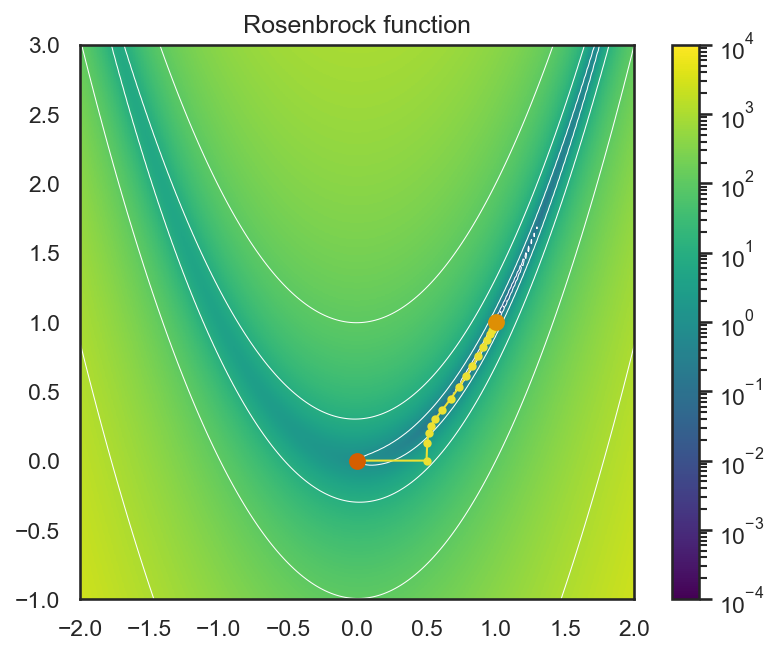

In [283]:
from matplotlib.colors import LogNorm

xs = np.linspace(-2.0, 2.0, 200)
ys = np.linspace(-1.0, 3.0, 200)
xs, ys = np.meshgrid(xs, ys)
extent = (-2.0, 2.0, -1.0, 3.0)
rosen = (1.0 - xs) ** 2.0 + 100.0 * (ys - xs**2.0) ** 2.0

fig, ax = plt.subplots()
mappable = ax.imshow(
    np.flip(rosen, axis=0), cmap="viridis", extent=extent, norm=LogNorm(vmin=1e-4, vmax=1.0e4)
)
ax.set(title="Rosenbrock function")
ax.contour(xs, ys, rosen, colors=["white"], linewidths=[0.5], norm=LogNorm(vmin=1e-4, vmax=1.0e4))
ax.scatter([1.0], [1.0], s=50, marker="o", color=color_palette[1], zorder=100)
ax.scatter([0.0], [0.0], s=50, marker="o", color=color_palette[3], zorder=100)

# 軌跡のプロット
pts = np.array(pts)
ax.plot(pts[:, 0], pts[:, 1], color=color_palette[8], marker="o", markersize="3.0", linewidth=1.0)

fig.colorbar(mappable, ax=ax)
plt.show()

この図では、$(0.0, 0.0)$の初期値から$(1.0, 1.0)$の最小値に至るまでの最適化の過程をマーカー付きの曲線で示している。各マーカーの位置を見てみると、徐々に最小値に至るスピードが遅くなりつつも、正しく関数の最小値を取る箇所に収束していることが分かる。

Rosenbrock関数の最小化については、解の初期値やニュートン法のステップ幅を変化させることで、収束が不安定になって最小解からはずれて・近づいてを繰り返すような軌跡を描くこともある。ぜひ、いろいろなパラメータで軌跡を描画して、その性質の理解に努めて欲しい。

:::{note}
ここでは、関数の勾配を求めて、勾配法により関数を最小化する問題を解いた。深層学習は、ニューラルネットのパラメータを変数として、その変数を同じく勾配法により最適化する問題であり、最小化する関数は**損失関数**(loss function)と呼ばれる (反対に目的を達成するために最大化される関数を**目的関数**と呼ぶ)。

ニューラルネットのパラメータ最適化(=訓練)には、ニュートン法や準ニュートン法のような損失関数の二階微分を考慮するような方法を用いることは少なく (ただしAdaSecant{cite}`gulcehre2014adasecant`のような二階微分を考慮する方法もある)、多くの場合は単純な確率的最急降下法やRMSprop, Adamのようなアルゴリズムが使われることが多い。これは、パラメータ数が多くなると、Hesse行列を求めるのに多くの計算量が必要になるためで、そうであれば、一階微分だけが求まれば実行できる最急降下法を安定化させるように工夫する方が良い、という発想である。
:::

## 深層学習

PyTorchを使った深層学習をするために準備すべきことはいくつかある。以下では、

- [データローダの実装](ssec:data-loader)
- [データセットの準備](sssec:dataset-preparation)
- [ネットワークの構築](ssec:network-architecture)
- [オプティマイザの準備](ssec:optimizer-preparation)
- [学習ループの実装](ssec:training-looop)

のそれぞれについて順に説明する。

(ssec:data-loader)
### データローダの作成

データローダとは、PyTorchを用いたニューラルネットワークの学習において、ミニバッチ学習を簡単にするための仕組みである。通常、深層学習には大量の訓練データが必要であり、それら全てを考慮したパラメータの更新方向(=勾配)を求めることは現実的ではない。

そこで、大量の訓練データから少数のデータ、すなわちミニバッチをサンプルし、そのミニバッチ内のデータによって与えられる勾配が、データ全体から求まる勾配の近似として十分に正しく動作することを仮定する。データから収集してくるミニバッチの数は`torch.utils.data.Dataset`型のサブクラスとして用意されたデータセット・クラスを引数にとる`torch.data.utils.data.DataLoader`によって制御できる。

では、上記のひらがな73文字データセットについて、まずはデータの読み出しを行う役割を持つデータセット・クラスを作成してみよう。データセット・クラスは`torch.utils.data.Dataset`型のサブクラスとして実装する。この際、コンストラクタと合わせて、データの総数を返す`__len__`関数と、データ1つをサンプルする`__getitem__`関数の二つを実装する。

In [284]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class HiraganaDataset(Dataset):
    """
    ひらがな73文字データセット
    """

    def __init__(self, dataroot, transform=None):
        super(HiraganaDataset, self).__init__()

        self.dataroot = dataroot
        self.transform = transform

        # 各ひらがなの画像が入っているフォルダを列挙
        folders = sorted([d for d in os.listdir(self.dataroot)])
        chars = [chr(int(d.replace("U", "0x"), 16)) for d in folders]
        n_chars = len(chars)
        char2num = {c: i for i, c in enumerate(chars)}
        folders = [os.path.join(self.dataroot, d) for d in folders]

        # 各フォルダに含まれる画像ファイルを列挙、配列に格納
        self.data = []
        for d in folders:
            char = os.path.basename(d).replace("U", "0x")
            char = chr(int(char, 16))
            num = char2num[char]

            image_files = [os.path.join(d, f) for f in os.listdir(d)]
            image_files = [f for f in image_files if f.endswith(".png")]
            image_files = sorted(image_files)
            self.data.extend([(f, num) for f in image_files])

    def __len__(self):
        """ファイルの総数を返す"""
        return len(self.data)

    def __getitem__(self, idx):
        """データ1つをサンプルする"""
        image_file, num = self.data[idx]
        image = Image.open(image_file)
        if image is None:
            raise IOError("Failed to load image: {:s}".format(f))

        if self.transform is not None:
            image = transform(image)

        return image, num

さて、上記のデータセット・クラスにはコンストラクタの引数に`transform`という変数が渡されている。PyTorchではTorchVisionの`transforms`モジュールに用意されたデータ操作のためのクラスを用いることで、簡単にデータの前処理を行うことができる。

例えば、[特徴量の抽出](sec:feature-extraction)で行っていたような

- 画像をグレースケールに変更
- 画像をランダムに回転、拡大・縮小

といった操作は `transforms.GrayScale`や`transforms.RandomAffine`によって実現することができる。複数の前処理操作を組み合わせる場合には、`transforms.Compose`に前処理を行うクラス・インスタンスの配列を渡せば良い。

In [ ]:
transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.RandomAffine(degrees=[-90, 90], scale=[0.8, 1.1]),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
    ]
)

dataset = HiraganaDataset(dataroot="hiragana73", transform=transform)

train_data, dataset = torch.utils.data.random_split(dataset, [n_samples, len(dataset) - n_samples])
test_data, _ = torch.utils.data.random_split(dataset, [n_samples, len(dataset) - n_samples])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

(ssec:network-architecture)=
### ネットワークの構築

In [ ]:
class Network(nn.Module):
    def __init__(self, in_features, out_features):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(in_features, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, out_features)

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = torch.relu(x)
        x = self.bn2(self.fc2(x))
        x = torch.relu(x)
        x = self.fc3(x)
        y = F.log_softmax(x, dim=1)
        return y

### 学習の準備

例のごとく、最初の{glue}`n_samples`個のデータだけを実験に用いる。

### 最適化手法の設定

In [ ]:
net = Network(48 * 48, 73)
optim = torch.optim.Adam(net.parameters(), lr=1.0e-3)

### 誤差関数の設定

In [ ]:
criterion = nn.NLLLoss()

In [ ]:
pbar = tqdm(train_loader)
for data in pbar:
    X, y_true = data
    X = X.reshape((X.size(0), -1))
    y_pred = net(X)
    loss = criterion(y_pred, y_true)
    acc = (torch.argmax(y_pred, dim=1) == y_true).float().mean()

    pbar.set_description("loss={:1.3f}, acc={:1.3f}".format(loss.item(), acc.item()))

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.update()

In [ ]:
pbar = tqdm(test_loader)
n_succ = 0
for data in pbar:
    X, y_true = data
    X = X.reshape((X.size(0), -1))
    y_pred = net(X)
    n_succ += (torch.argmax(y_pred, dim=1) == y_true).float().sum()

print("Acc: {:.3f}".format(n_succ / len(test_data)))

## 畳み込みニューラルネット

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc3 = nn.Linear(12 * 12 * 32, out_channels)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = torch.relu(x)
        x = self.bn2(self.conv2(x))
        x = torch.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.reshape((x.size(0), -1))
        x = self.fc3(x)
        y = F.log_softmax(x, dim=1)
        return y

In [ ]:
net = CNN(1, 73)
optim = torch.optim.Adam(net.parameters(), lr=1.0e-3)

In [ ]:
pbar = tqdm(train_loader)
for data in pbar:
    X, y_true = data
    y_pred = net(X)
    loss = criterion(y_pred, y_true)
    acc = (torch.argmax(y_pred, dim=1) == y_true).float().mean()

    pbar.set_description("loss={:1.3f}, acc={:1.3f}".format(loss.item(), acc.item()))

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.update()

In [ ]:
pbar = tqdm(test_loader)
n_succ = 0
for data in pbar:
    X, y_true = data
    y_pred = net(X)
    n_succ += (torch.argmax(y_pred, dim=1) == y_true).float().sum()

print("Acc: {:.3f}".format(n_succ / len(test_data)))

## 練習問題

- 上記のニュートン法により得られた関数最小化の軌跡を、単純な[最急降下法](https://en.wikipedia.org/wiki/Gradient_descent)ならびに一階導関数だけを用いてHesse行列を近似する[準ニュートン法](https://en.wikipedia.org/wiki/Quasi-Newton_method)と比較せよ。

## 参考文献

```{bibliography}
:filter: docname in docnames
```